In [1]:
!pip install tensorflow_hub

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support
  Using cached https://files.pythonhosted.org/packages/fb/9d/d5772f94e31431cdb56a8bb2c34d8839bb7d7621f2a5959f4ef43207d7ac/tensorflow_hub-0.8.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/65/eb/1f97cb97bfc2390a276969c6fae16075da282f5058082d4cb10c6c5c1dba/six-1.14.0-py2.py3-none-any.whl
  Found existing installation: six 1.11.0
    Uninstalling six-1.11.0:
      Successfully uninstalled six-1.11.0
You should consider upgrading via the 'pip install --upgrade pip' command.


In [54]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import tensorflow_hub as hub
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [13]:
print("TF Version: ", tf.__version__)
print("TF-Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.test.is_gpu_available())

TF Version:  2.1.0
TF-Hub version:  0.8.0
Eager mode enabled:  True
GPU available:  True


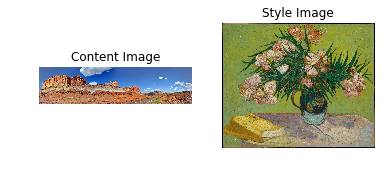

In [51]:
content_path = 'test_image.jpg'
style_path = 'oleanders-vincent-van-gogh.jpg'

content_image = plt.imread(content_path)
style_image = plt.imread(style_path)
plt.subplot(1, 2, 1)
plt.title('Content Image')
plt.axis('off')
imshow(content_image)
plt.subplot(1, 2, 2)
plt.title('Style Image')
plt.axis('off')
imshow(style_image)

In [15]:

def image_to_tensor(path_to_img, size=[256, 256], reshape=False):
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3, dtype=tf.float32)
    
    # Resize the image to specific dimensions
    if reshape: img = tf.image.resize(img, size)
    img = img[tf.newaxis, :]
    return img

In [7]:

def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    tensor = tensor[0]
    plt.figure(figsize=(20,10))
    plt.axis('off')
    return plt.imshow(tensor)

In [64]:
from PIL import Image

def generate_image(content_path, style_path):
    content_image_tensor = image_to_tensor(content_path)
    style_image_tensor = image_to_tensor(style_path, reshape=True)
    hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
    combined_result = hub_module(tf.constant(content_image_tensor), tf.constant(style_image_tensor))[0]
    return combined_result[0].numpy()

def save_image(image, filename):
    im = Image.fromarray((image * 255).astype(np.uint8))
    im.save(f"art/{filename}")

In [73]:
content_path = 'DSC_1143.JPG'
style_path = 'styles/pexels-photo-1585325.jpeg'

im = generate_image(content_path, style_path)

In [74]:
save_image(im, 'ds.jpg')

In [75]:
!ls

art	      image.png			      res.jpeg	      transfer.ipynb
building.jpg  oleanders-vincent-van-gogh.jpg  styles	      Untitled Folder
DSC_1143.JPG  picasso.jpg		      test_image.jpg  utah_at_dawn.png


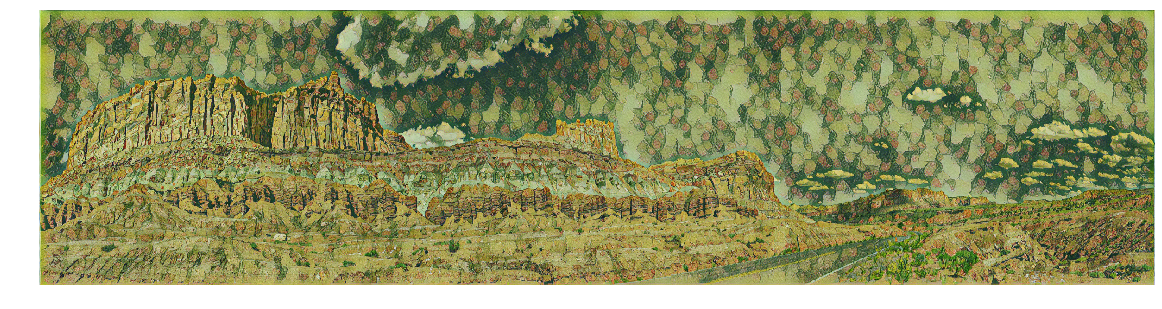

In [53]:

res = tensor_to_image(combined_result)

In [40]:
combined_result[0].numpy().shape

(1272, 5172, 3)

In [29]:
img = combined_result[0].numpy()

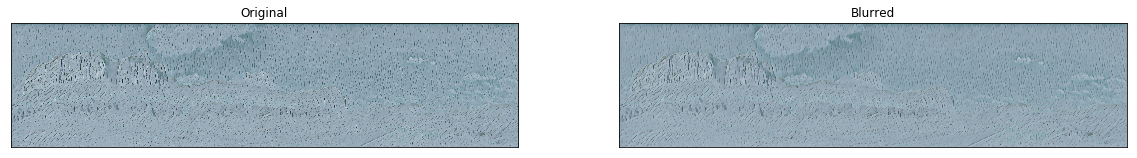

In [32]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


blur = cv2.blur(img,(5,5))

plt.figure(figsize=(20, 20))
plt.subplot(121),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(blur),plt.title('Blurred')
plt.xticks([]), plt.yticks([])
plt.show()

Docstring:
blur(src, ksize[, dst[, anchor[, borderType]]]) -> dst
.   @brief Blurs an image using the normalized box filter.
.   
.   The function smooths an image using the kernel:
.   
.   \f[\texttt{K} =  \frac{1}{\texttt{ksize.width*ksize.height}} \begin{bmatrix} 1 & 1 & 1 &  \cdots & 1 & 1  \\ 1 & 1 & 1 &  \cdots & 1 & 1  \\ \hdotsfor{6} \\ 1 & 1 & 1 &  \cdots & 1 & 1  \\ \end{bmatrix}\f]
.   
.   The call `blur(src, dst, ksize, anchor, borderType)` is equivalent to `boxFilter(src, dst, src.type(),
.   anchor, true, borderType)`.
.   
.   @param src input image; it can have any number of channels, which are processed independently, but
.   the depth should be CV_8U, CV_16U, CV_16S, CV_32F or CV_64F.
.   @param dst output image of the same size and type as src.
.   @param ksize blurring kernel size.
.   @param anchor anchor point; default value Point(-1,-1) means that the anchor is at the kernel
.   center.
.   @param borderType border mode used to extrapolate pixels outside of the